# Generating Synthetic Images with DCGANs in Keras

### Index
Importing Libraries <br>
Load and Preprocess the Fashion MNIST Data <br>
Create Batches of Shuffled Training Data <br>
Build the Generator Network for DCGAN <br>
Build the Discriminator Network for DCGAN <br>
Compile the Deep Convolutional Generative Adversarial Network (DCGAN) <br>
Define the Training Procedure <br>
Train DCGAN <br>
Generate Synthetic Images with DCGAN<br>

### 1. Importing Libraries

In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print("Tensorflow Version ", tf.__version__)

Tensorflow Version  2.3.0


### 4. Load and Preprocess the Fashion MNIST Data

In [3]:
(x_train, y_train),(x_test,y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
x_train = x_train.astype(np.float32) / 255.0
X_test = x_test.astype(np.float32) / 255.0

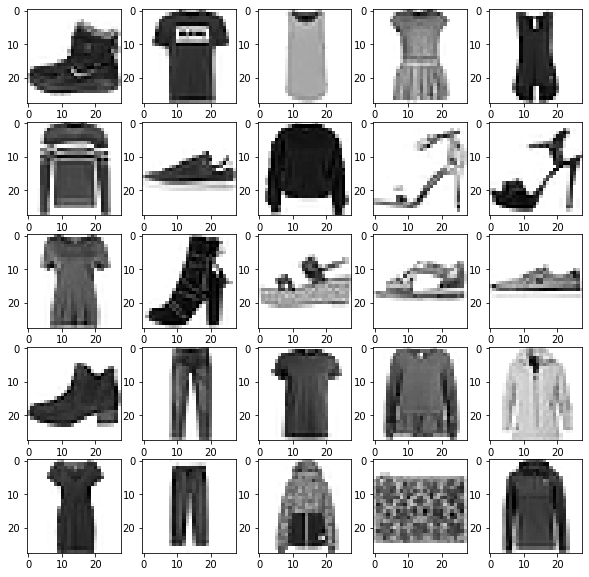

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    plt.xticks=[]
    plt.yticks=[]
plt.show()


function to display the noise

In [6]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

### 5. Creating batches of Shuffled Training Data

In [7]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

### 6. Building the Generator Network for DCGAN

The Architecture guidelines for stable Deep Convolutional GANs:<br>
<ul>
<li> Replace any pooling layers with strided convolutions(discriminator) and fractional-strided convolutions(generators)
<li>Use batchnorm in both the generator and the discriminator.  
<li>Remove fully connected hidden layers for deeper architecture.
<li>Use ReLU activation in generator for all layers for deeper architectures.
<li>Use LeakyReLU activation in the discriminator for all layers.
</ul><br>
source: Radford et al, "Unsupervised Representation Learning with Deep Convolutional Generative Adversial Networks" , ICLR 2016

In [8]:
num_features = 100
generator = keras.models.Sequential()
generator.add(keras.layers.Dense(7*7*128, input_shape=[num_features]))
generator.add(keras.layers.Reshape([7,7,128]))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same',activation='selu'))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh'))


In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

Random Noise creation

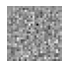

In [10]:
noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise,training=False)
show(generated_image, 1)

### 7. Building the discriminator Network for DCGAN

In [11]:
discriminator = keras.models.Sequential()
discriminator.add(keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28,28,1]))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Conv2D(128,(5,5),(2,2), padding='same'))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1,activation='sigmoid'))

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [13]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.4985054]], shape=(1, 1), dtype=float32)


### 8. Compiling the Deep Convolutional Generative Adversial Network(DCGAN)

In [14]:
discriminator.compile(loss='binary_crossentropy',optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy',optimizer='rmsprop')

In [15]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


### 9. Defining Training Procedure

In [16]:
seed = tf.random.normal(shape=[batch_size,100])

In [17]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1,epochs)) 
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size,num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch],axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real,y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)



    

### Function to generate and save images

In [18]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### 10. Training DCGAN

In [19]:
x_train_dcgan = x_train.reshape(-1,28,28,1)*2.-1.

In [20]:
 batch_size =32 
 dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
 dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

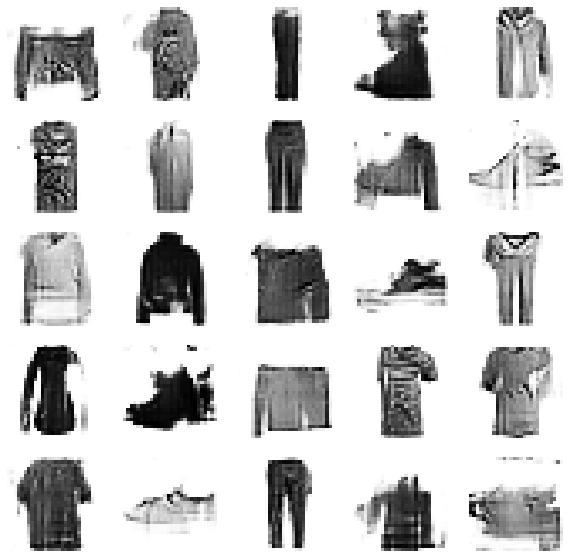

CPU times: user 5min 39s, sys: 19.9 s, total: 5min 59s
Wall time: 6min 10s


In [21]:
%%time
train_dcgan(gan,dataset,batch_size,num_features,epochs=10)

### 11. Generating Synthetic Images with DCGAN

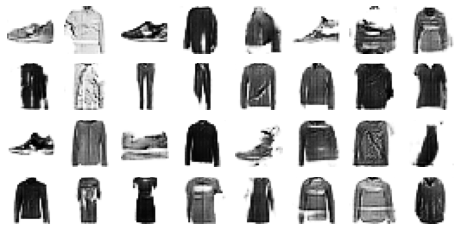

In [24]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

### 12.Generating GIF 

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)

### Conclusion
<br>
Generated synthetic images using Deep Convolutional GANs. Successfully generated fake images from the fashion_mnist dataset. 